# Pytorch experiments


In [1]:
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
from dataloader import DataLoader, distance
from os.path import abspath
from entriesprocessor import EntriesProcessor
from trainer import Trainer
from model import Decoder, Encoder
import torch

EMBEDDING_SIZE = 10
HIDDEN_SIZE = 200
print(abspath('./'))
loader = DataLoader(10)
loader.parse_person_corpus(abspath('../Persons-1000/collection'))
loader.parse_rdf_corpus(abspath('../../corpus_for_pakhomov_2'))

C:\Users\Sdernal\Desktop\Jackals\TextNormalization\WithPytorch
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Абдулла Гюль.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Адам Осмаев.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Азим Исабеков.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Глухов.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Ломая.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Александр Медведько.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Анатолий Бибилов.xml
'NoneType' object has no attribute 'text' C:\Users\Sdernal\Desktop\Jackals\corpus_for_pakhomov_2\Андрей Аршавин.xml
'None

In [3]:
diffs = []
for entry in loader.entries:
    entry_start = entry.offset - entry.context_offset
    entry_end = entry_start + entry.length
    entry_text = entry.context[entry_start:entry_end]
    diff_len = abs(len(entry_text) - len(entry.value))
    diffs.append(diff_len)

(array([ 21970.,   7444.,   4194.,    650.,   1038.,    809.,    858.,
           979.,    539.,    205.,    193.,     61.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 12 Patch objects>)

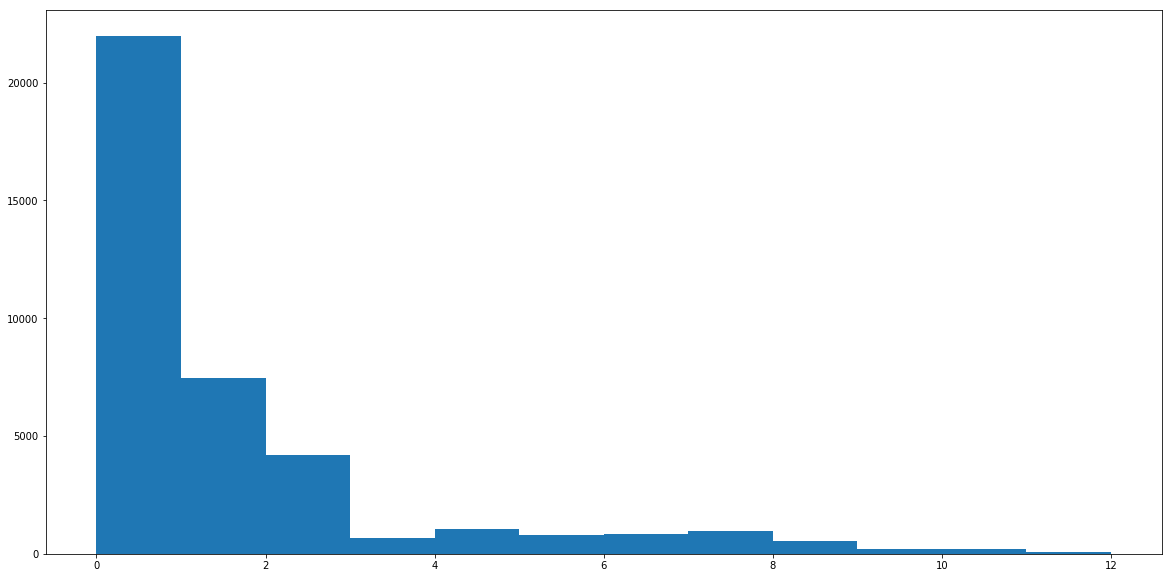

In [4]:
fig = plt.figure(figsize=(20,10))
plt.hist(diffs, range=(0,12), bins=range(0,13))

In [5]:
def words(text):
    wds = filter(lambda x: len(x) > 0, re.split('\.|-| ', text))
    return list(wds)

def delete_excess(text, value):
    text_words = text.split()
    value_words = value.split()
#     if len(value_words) < len(text_words):
#         print('\t', text,'\t', value)
#         return None
    result = []
    for t in text_words:
        for v in value_words:
            if distance(t, v) < 3:
                result.append(v)
    if len(text_words) == len(result):
#         print('\t', text,'\t', ' '.join(result), '\t', value)
        return ' '.join(result)

In [6]:
bad_entries = []
edited_enties = []
for entry in loader.entries:
    entry_start = entry.offset - entry.context_offset
    entry_end = entry_start + entry.length
    entry_text = entry.context[entry_start:entry_end]
    diff_len = abs(len(words(entry_text)) - len(words(entry.value)))
    if diff_len > 0:  
        try_to_fix = delete_excess(entry_text, entry.value)
        if try_to_fix is None:
            bad_entries.append(entry)
        else:
            entry.value = try_to_fix
#             print(entry)
            edited_enties.append(entry)
    else:
        edited_enties.append(entry)

In [8]:
len(bad_entries)
# for entry in bad_entries:
#     print(entry)

99

In [9]:
print(len(edited_enties))
uniq_values = set([entry.value for entry in edited_enties])
print(len(uniq_values))

38854
14848


In [10]:
ep = EntriesProcessor(20,40)
# voc_size = 10
ep.process(edited_enties)
voc_size = ep.symbols_counter

In [11]:
print(len(ep.X_data_test), len(ep.X_data_train))

3480 30287


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_size=voc_size, hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE).to(device)
decoder = Decoder(hidden_size=HIDDEN_SIZE, embedding_size=EMBEDDING_SIZE, output_size=voc_size, max_length=40).to(device)
trainer = Trainer(encoder,decoder,ep,max_input_length=40, max_output_length=20)

In [13]:
train_losses_all, test_losses_all = [], []

In [76]:
train_losses, test_losses = trainer.train(1, batch_size=256)
train_losses_all.extend(train_losses)
test_losses_all.extend(test_losses)


Epoch 1
	Train Loss: 0.039166 	 Time: 23s
	Test Loss: 0.061804 	 Time: 0s


In [77]:
a,b,c = trainer.evaluate_with_attn(ep.X_data_test[8:9])

In [34]:
from matplotlib import ticker
def showAttention(input, result, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['#'] + input)
    ax.set_yticklabels(['#'] + result)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


['#', '#', 'г', 'о', 'с', 'п', 'о', 'д', 'и', 'н', 'а', '_', 'х', 'а', 'б', 'и', 'р', 'о', 'в', 'а', '_', 'в', '_', 'п', 'а', 'р', 'т', 'и', 'и', '_', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']


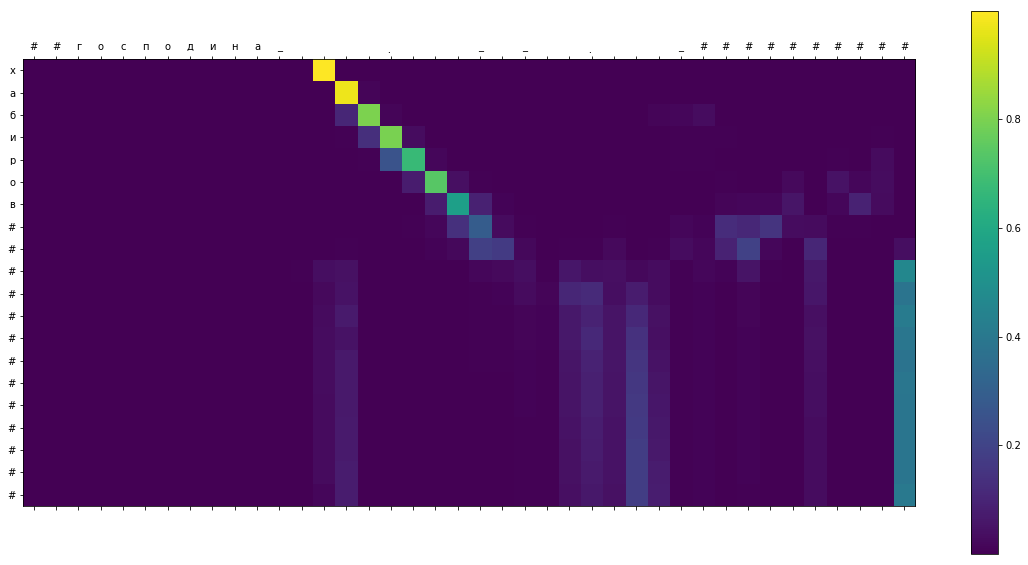

In [78]:
a2 = []
b2 = []
for elem in a:
    if elem == ' ':
        a2.append('_')
    elif len(elem) != 1:
        a2.append('#')    
    else:
        a2.append(elem)

for elem in b:
    if elem == ' ':
        b2.append('_')
    elif len(elem) != 1:
        b2.append('#')    
    else:
        b2.append(elem)
print(a2)
showAttention(a2,b2,c)

In [67]:
ethalons, results, inputs, matched, distances = trainer.test_model(False)

results_cleaned_2_3.csv

In [54]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.801149425287
Mean distance:  0.307471264368


results_cleaned_2_5.csv

In [68]:
import numpy as np
print('Accuracy: ', np.mean(matched))
print('Mean distance: ', np.mean(distances))

Accuracy:  0.811781609195
Mean distance:  0.316666666667


In [49]:
print(ethalons[:10])
print(results[:10])
print(inputs[:10])
print(matched[:10])
print(distances[:10])

['игорь артемьев', 'михаил прохоров', 'игорь андрющенко', 'ровенский', 'ровенский', 'алексей миллер', 'юрий хардиков', 'айрат мурзагалиев', 'андрей воробьев', 'андрей раппопорт']
['игорь артемьев', 'михаил прохоров', 'игорь андрющенко', 'ровенский', 'ровенский', 'алексей миллер', 'юрий хардиков', 'айрат мурзагалиев', 'андрей воробьев', 'андрей раппопорт']
['глава фас игорь артемьев заявил, ч', 'году, при михаиле прохорове.\n\r\n\rкроме', 'правлению игорь андрющенко называет ', ' господин ровенский, позиция,', 'господина ровенского, он с 1 и', 'газпрома> алексея миллера, члена со', 'ектом сао юрием хардиковым. 19 январ', 'резидента айрат мурзагалиев, вчера му', 'й россии" андрей воробьев заявил "ъ', 'андрей раппопорт выбрался ']
[True, True, True, True, True, True, True, True, True, True]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


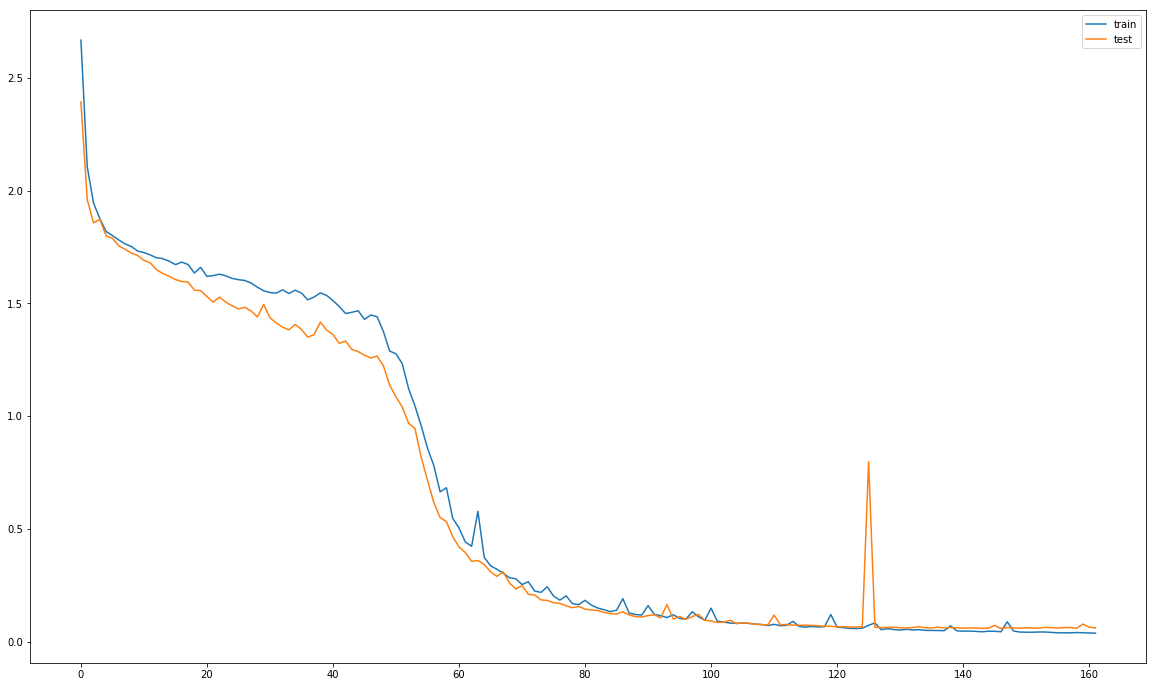

In [83]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all, label='train')
plt.plot(test_losses_all, label='test')
plt.legend()
plt.show()

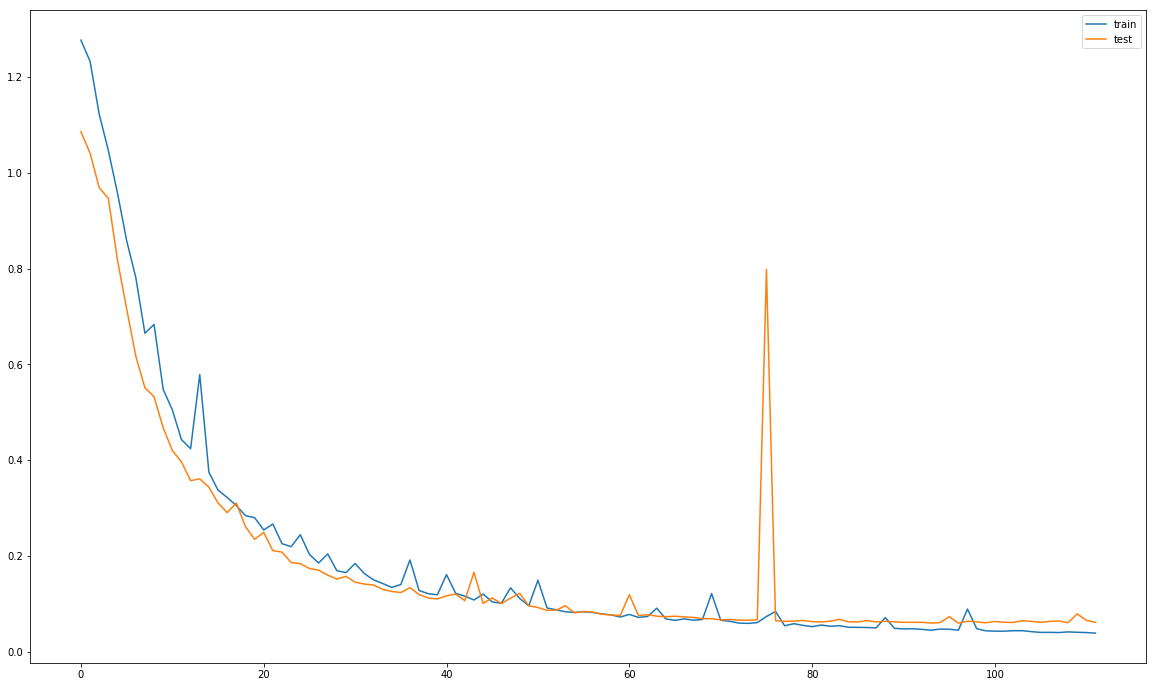

In [84]:
plt.figure(figsize=(20,12))
plt.plot(train_losses_all[50:], label='train')
plt.plot(test_losses_all[50:], label='test')
plt.legend()
plt.show()

In [69]:
encoded_inputs = list(map(lambda x : x.encode('windows-1251', errors='replace').decode('windows-1251'), inputs))

In [70]:
import pandas as pd

data = {'ethalon' : ethalons, 'result' : results, 'input' : encoded_inputs, 'matched' : matched, 'distance' : distances}
df = pd.DataFrame(data=data, columns=['ethalon', 'result', 'input', 'matched', 'distance'])

In [71]:
df.head(20)

,ethalon,result,input,matched,distance
0,григорий карасин,григорий карасин,ел россии григорий карасин заявил в,True,0
1,путин,путин,недоимки. путин попросил,True,0
2,путин,путин,а котором путин раскритик,True,0
3,путин,путин,"по мнению путина, это дела",True,0
4,путин,путин,ступления путина глава фас,True,0
5,путин,путин,"ступления путина, его ведо",True,0
6,буш,буш,ия с сша. буш несколько,True,0
7,игорь юсуфов,игорь юсуфов,"дничеству игоря юсуфова, председа",True,0
8,хабиров,хабиров,господина хабирова в партии,True,0
9,хабиров,хабиров,господин хабиров был пригл,True,0


In [72]:
df.to_csv('results_cleaned_2_5.csv', encoding='windows-1251')

In [ ]:
torch.save(encoder.state_dict(), 'encoder.pt')
torch.save(decoder.state_dict(),'decoder.pt')